# Character Classification
This notebook contains all steps of OCR

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
from ipywidgets import Button, Text, HBox, VBox
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
#from ocr import page, words, charSeg
from ocr.normalization import imageNorm, letterNorm
from ocr import page, words, charSeg
# Helpers
from ocr.helpers import implt, resize
from ocr.tfhelpers import Graph

### Global Variables

In [9]:
IMG = 'text'
LANG = 'en'
LOC = 'models/char-clas/' + LANG + '/CharClassifier'

CHARS = []

if LANG == 'cz':
    CHARS = ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
             'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
             'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
             'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
             'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
             'x', 'y', 'z', 'Á', 'É', 'Í', 'Ó', 'Ú', 'Ý', 'á',
             'é', 'í', 'ó', 'ú', 'ý', 'Č', 'č', 'Ď', 'ď', 'Ě',
             'ě', 'Ň', 'ň', 'Ř', 'ř', 'Š', 'š', 'Ť', 'ť', 'Ů',
             'ů', 'Ž', 'ž']
else:
    CHARS = ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
             'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
             'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
             'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
             'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
             'x', 'y', 'z']

## Load Trained Model

In [10]:
charClass = Graph(LOC)

INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier


## Load image

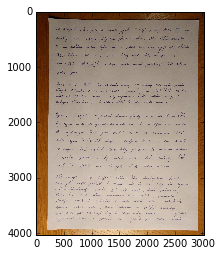

In [11]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

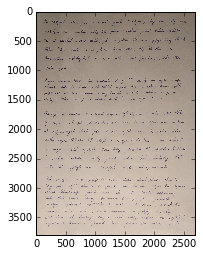

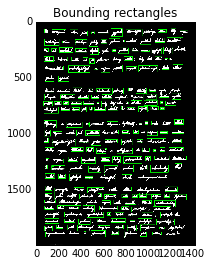

In [12]:
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

# Simple UI using widgets

In [13]:
class Cycler:
    """ Cycle through the words and recognise them """
    height = 60
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.actual = image      # Current image of word
        self.nextImg()
        
    def letters(self, b=None):
        """ Recognising letters and printing a word """
        idx = 0
        gaps = self.gaps
        word = ""
        
        while idx < len(gaps) - 1:
            # Cutting char image - for save function
            char = self.actual[0:self.height, gaps[idx]:gaps[idx+1]]
            
            data = np.multiply(np.reshape(letterNorm(char), (1, 4096)).astype(np.float32),
                               1.0 / 255.0)

            charIdx = charClass.run(data)[0]
            if charIdx != 0:
                word += CHARS[charIdx]
            
            idx += 1
        print("Word: " + word)

    def nextImg(self, b=None):
        """ Getting next image from the array """
        clear_output()
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            
            implt(img, t='Index: ' + str(self.index))            
            self.actual = imageNorm(img, self.height)
            # Separate letters
            self.gaps = charSeg.segmentation(self.actual, debug=True)
            # Recognise letters
            self.letters()
            
            self.index += 1
        else:
            print("END")

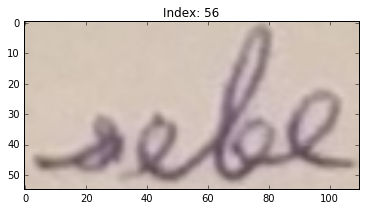

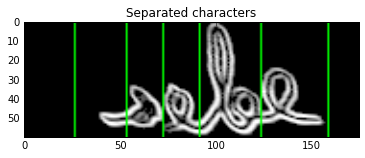

Word: sebe


In [14]:
#  Last index
LAST_INDEX = 56
# Class cycling through text positions
cycler = Cycler(crop, bBoxes, LAST_INDEX)

bNexi = Button(description="Next Image")

bNexi.on_click(cycler.nextImg)

display(bNexi)